# Imports

In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [93]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [94]:
train.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


Test set is much more bigger than train set, and the latter is quite small so it will be challenge to create a model which will generalize well.  

In [95]:
print("Train set samples:", train.shape[0])
print("Train set features:", train.shape[1])

Train set samples: 250
Train set features: 302


In [96]:
print("Test set samples:", test.shape[0])
print("Test set features:", test.shape[1])

Test set samples: 19750
Test set features: 301


# Base models

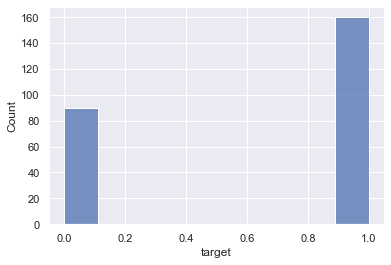

In [97]:
sns.histplot(data=train, x="target");

In [98]:
output = pd.DataFrame({"id": test["id"], "target": 1})
output.to_csv("submissions/base_predictions.csv", index=False)

In base model predictions I set all values to 1 since it is the most frequent value in our train set and after submission I got 0.5 score. It seems that one half of test data is equal to 0's and another - 1's. Let's try simple logistic regression model before diving deeper to feature engineering and more complex models. Logistic regression model improved our score by 0.13 - 0.63.

In [99]:
X_train = train.drop(columns=["id", "target"])
y_train = train["target"]
X_test = test.drop(columns=["id"])

log_reg = LogisticRegression().fit(X_train, y_train)
predictions = log_reg.predict(X_test)

In [100]:
output = pd.DataFrame({"id": test["id"], "target": predictions})
output.to_csv("submissions/base_predictions.csv", index=False)

# Main models

In [101]:
X_train = train.drop(columns=["id", "target"])
y_train = train["target"]
X_test = test.drop(columns=["id"])

## Logistic Regression

In [155]:
log_reg = LogisticRegression(random_state=42, penalty="l1", C=0.1, solver="liblinear")

In [156]:
log_pipe = Pipeline(
    steps=[
        ("selector", SelectFromModel(estimator=log_reg, threshold="2.5*mean")),
        ("model", log_reg)
    ]
)
 
log_probs = cross_val_predict(log_pipe, X_train, y_train, method="predict_proba")
log_score_rt = round(roc_auc_score(y_train, log_probs[:, 1]), 3)
print("Cross-validation score:", log_score_rt)

Cross-validation score: 0.808


In [154]:
params = {
    "model__penalty": ["l1"],
    "model__C": [0.1],
    "model__solver": ["liblinear"]
}

In [152]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)
log_search = GridSearchCV(estimator=log_pipe, param_grid=params, scoring=roc_auc_scorer, refit=True)
log_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('selector',
                                        SelectFromModel(estimator=LogisticRegression(random_state=42),
                                                        threshold='2.5*mean')),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             param_grid={'model__C': [0.05, 0.1, 0.2], 'model__penalty': ['l1'],
                         'model__solver': ['liblinear']},
             scoring=make_scorer(roc_auc_score, needs_proba=True))

In [153]:
best_params = log_search.best_params_
best_params

{'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}

In [157]:
log_pipe.fit(X_train, y_train)
log_predictions = log_pipe.predict_proba(X_test)

output = pd.DataFrame({"id": test["id"], "target": log_predictions[:, 1]})
output.to_csv("submissions/log_predictions.csv", index=False)

## Naive Bayes

In [105]:
nb = GaussianNB()

nb_probs = cross_val_predict(nb, X_train, y_train, method="predict_proba")
nb_score_rt = round(roc_auc_score(y_train, nb_probs[:, 1]), 3)
print("Cross-validation score:", nb_score_rt)

Cross-validation score: 0.704


In [106]:
nb.fit(X_train, y_train)
nb_predictions = nb.predict_proba(X_test)

output = pd.DataFrame({"id": test["id"], "target": nb_predictions[:, 1]})
output.to_csv("submissions/nb_predictions.csv", index=False)

## Stochastic gradient descent

Better score was achieved without hyper-parameters tuning with GridSearchCV. 

In [107]:
sgd = SGDClassifier(loss="log", random_state=42)

sgd_pipe = Pipeline(
    steps=[
        ("selector", SelectFromModel(estimator=sgd, threshold="2.2*mean")),
        ("model", sgd)
    ]
)

sgd_probs = cross_val_predict(sgd_pipe, X_train, y_train, method="predict_proba")
sgd_score_rt = round(roc_auc_score(y_train, sgd_probs[:, 1]), 3)
print("Cross-validation score:", sgd_score_rt)

Cross-validation score: 0.719


In [108]:
params = {
    "model__penalty": ["elasticnet"],
    "model__l1_ratio": [0.08],
    "model__max_iter": [800]
}

In [109]:
grid_search = GridSearchCV(estimator=sgd_pipe, param_grid=params, scoring="roc_auc", refit="roc_auc")
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('selector',
                                        SelectFromModel(estimator=SGDClassifier(loss='log',
                                                                                random_state=42),
                                                        threshold='2.2*mean')),
                                       ('model',
                                        SGDClassifier(loss='log',
                                                      random_state=42))]),
             param_grid={'model__l1_ratio': [0.08], 'model__max_iter': [800],
                         'model__penalty': ['elasticnet']},
             refit='roc_auc', scoring='roc_auc')

In [110]:
best_params = grid_search.best_params_
best_params

{'model__l1_ratio': 0.08,
 'model__max_iter': 800,
 'model__penalty': 'elasticnet'}

In [111]:
sgd_pipe.fit(X_train, y_train)
sgd_predictions = sgd_pipe.predict_proba(X_test)

output = pd.DataFrame({"id": test["id"], "target": sgd_predictions[:, 1]})
output.to_csv("submissions/sgd_predictions.csv", index=False)

## K-nearest neighbors 

In [112]:
knn = KNeighborsClassifier()

knn_probs = cross_val_predict(knn, X_train, y_train, method="predict_proba")
knn_score_rt = round(roc_auc_score(y_train, knn_probs[:, 1]), 3)
print("Cross-validation score:", knn_score_rt)

Cross-validation score: 0.563


In [113]:
knn.fit(X_train, y_train)
knn_predictions = knn.predict_proba(X_test)

output = pd.DataFrame({"id": test["id"], "target": knn_predictions[:, 1]})
output.to_csv("submissions/knn_predictions.csv", index=False)

## Decision tree

In [114]:
dtree = DecisionTreeClassifier(random_state=42)

dtree_pipe = Pipeline(
    steps=[
        ("selector", SelectFromModel(estimator=dtree, threshold="1.4*mean")),
        ("model", dtree)
    ]
)

dtree_probs = cross_val_predict(dtree_pipe, X_train, y_train, method="predict_proba")
dtree_score_rt = round(roc_auc_score(y_train, dtree_probs[:, 1]), 3)
print("Cross-validation score:", dtree_score_rt)

Cross-validation score: 0.534


In [115]:
dtree_pipe.fit(X_train, y_train)
dtree_predictions = dtree_pipe.predict_proba(X_test)

output = pd.DataFrame({"id": test["id"], "target": dtree_predictions[:, 1]})
output.to_csv("submissions/dtree_predictions.csv", index=False)

## Random forest

In [116]:
forest = RandomForestClassifier(random_state=42)

forest_pipe = Pipeline(
    steps=[
        ("selector", SelectFromModel(estimator=forest, threshold="2.4*mean")),
        ("model", forest)
    ]
)

forest_probs = cross_val_predict(forest_pipe, X_train, y_train, method="predict_proba")
forest_score_rt = round(roc_auc_score(y_train, forest_probs[:, 1]), 3)
print("Cross-validation score:", forest_score_rt)

Cross-validation score: 0.662


In [117]:
forest_pipe.fit(X_train, y_train)
forest_predictions = forest_pipe.predict_proba(X_test)

output = pd.DataFrame({"id": test["id"], "target": forest_predictions[:, 1]})
output.to_csv("submissions/forest_predictions.csv", index=False)

## Support vector machine

In [118]:
svm = SVC(probability=True)

svm_probs = cross_val_predict(svm, X_train, y_train, method="predict_proba")
svm_score_rt = round(roc_auc_score(y_train, svm_probs[:, 1]), 3)
print("Cross-validation score:", svm_score_rt)

Cross-validation score: 0.746


In [119]:
svm.fit(X_train, y_train)
svm_predictions = svm.predict_proba(X_test)

output = pd.DataFrame({"id": test["id"], "target": svm_predictions[:, 1]})
output.to_csv("submissions/svm_predictions.csv", index=False)

# Averaged predictions

In [120]:
stacked_predictions = np.column_stack((log_predictions[:, 1], nb_predictions[:, 1], sgd_predictions[:, 1],
                                       forest_predictions[:, 1], svm_predictions[:, 1]))

averaged_predictions = stacked_predictions.mean(1).reshape(19750,)

output = pd.DataFrame({"id": test["id"], "target": averaged_predictions})
output.to_csv("submissions/averaged_predictions.csv", index=False)

# Scores

In [159]:
log_base_score = 0.74757
nb_base_score = 0.69792
sgd_base_score = 0.69792
knn_base_score = 0.56267
dtree_base_score = 0.51736
forest_base_score = 0.65295
svm_base_score = 0.75347
avg_base_score = None

log_score = 0.808
nb_score = 0.704
sgd_score = 0.719
knn_score = 0.563
dtree_score = 0.534
forest_score = 0.662
svm_score = 0.746
avg_score = None

kaggle_base_log_score = 0.634
kaggle_base_nb_score = 0.591
kaggle_base_sgd_score = 0.617
kaggle_base_knn_score = 0.543
kaggle_base_dtree_score = 0.559
kaggle_base_forest_score = 0.529
kaggle_base_svm_score = 0.510
kaggle_base_avg_score = None

kaggle_log_score = 0.834
kaggle_nb_score = 0.661
kaggle_sgd_score = 0.764
kaggle_knn_score = 0.561
kaggle_dtree_score = 0.565
kaggle_forest_score = 0.734
kaggle_svm_score = 0.703
kaggle_avg_score = 0.792

scores_table = pd.DataFrame({"Base Score": [log_base_score, nb_base_score, sgd_base_score, knn_base_score, dtree_base_score,
                                            forest_base_score, svm_base_score, avg_base_score],
                             "Score": [log_score, nb_score, sgd_score, knn_score, dtree_score, forest_score, svm_score, avg_score],
                             "Kaggle Base Score": [kaggle_base_log_score, kaggle_base_nb_score, kaggle_base_sgd_score, kaggle_base_knn_score, kaggle_base_dtree_score, 
                                                   kaggle_base_forest_score, kaggle_base_svm_score, kaggle_base_avg_score],
                             "Kaggle Score": [kaggle_log_score, kaggle_nb_score, kaggle_sgd_score, kaggle_knn_score, kaggle_dtree_score,
                                              kaggle_forest_score, kaggle_svm_score, kaggle_avg_score],
                             "Real-Time Score": [log_score_rt, nb_score_rt, sgd_score_rt, knn_score_rt, dtree_score_rt, forest_score_rt,
                                                 svm_score_rt, None]
                             }
                            ).set_axis(
                                 ["Logistic Regression", "Naive Bayes", "Stochastic gradient descent", "K-nearest neighbors", 
                                  "Decision Tree", "Random forest", "Support vector machine", "Averaged classifiers"], axis="index"
                                 )
                             
scores_table

,Base Score,Score,Kaggle Base Score,Kaggle Score,Real-Time Score
Logistic Regression,0.74757,0.808,0.634,0.834,0.808
Naive Bayes,0.69792,0.704,0.591,0.661,0.704
Stochastic gradient descent,0.69792,0.719,0.617,0.764,0.719
K-nearest neighbors,0.56267,0.563,0.543,0.561,0.563
Decision Tree,0.51736,0.534,0.559,0.565,0.534
Random forest,0.65295,0.662,0.529,0.734,0.662
Support vector machine,0.75347,0.746,0.510,0.703,0.746
Averaged classifiers,NaN,NaN,NaN,0.792,NaN
